In [7]:
import pandas as pd

# Load the Excel file
desktop_path = 'C:/Users/user/Desktop'
file_name = 'new_DBGAPS2024_pricevolume.xlsx'
xls = f'{desktop_path}/{file_name}'
file_path = f'{desktop_path}/{file_name}'
# Check sheet names to understand the structure of the file
# sheet_names = xls.sheet_names
# sheet_names


# Load the "수정시가" sheet into a DataFrame
adjusted_opening_prices_df = pd.read_excel(file_path, sheet_name='수정시가')

# Display the first few rows of the dataframe to understand its structure
adjusted_opening_prices_df.head()



# Set the date column as the index
adjusted_opening_prices_df.set_index('date', inplace=True)

# Calculate daily returns
returns_df = adjusted_opening_prices_df.pct_change().dropna()

# Display the first few rows of the returns dataframe
returns_df.head()



,A130730,A138230,A139660,A114800,A130680,A132030,A182490,A136340,A148070,A192090,A238720,A195930,A143850,A232080,A069500
date,,,,,,,,,,,,,,,
2016-03-04,0.000101,-0.010725,0.011770,0.000605,0.002805,0.014606,0.002605,-0.002013,-0.009892,0.009761,0.013462,-0.001551,0.005849,0.019174,0.000835
2016-03-07,0.000146,-0.010841,0.011634,-0.003630,0.039161,0.003085,0.004763,0.001582,0.003224,0.006990,0.000474,0.003107,0.005384,0.004631,0.002258
2016-03-08,-0.000101,0.002367,-0.000479,-0.001214,0.039031,0.001538,0.000970,0.000145,-0.001040,0.001329,-0.001897,-0.002581,-0.002142,-0.006434,0.001421
2016-03-09,-0.000045,0.012246,-0.002876,0.010334,-0.034974,-0.001535,-0.000969,-0.001435,0.001585,-0.012389,-0.019477,-0.008799,-0.004938,-0.001836,-0.010224
2016-03-10,0.000202,-0.006481,-0.008173,-0.008424,0.025503,-0.007688,-0.001077,0.000189,-0.002715,0.001493,0.010174,0.009399,0.003452,0.007359,0.008253


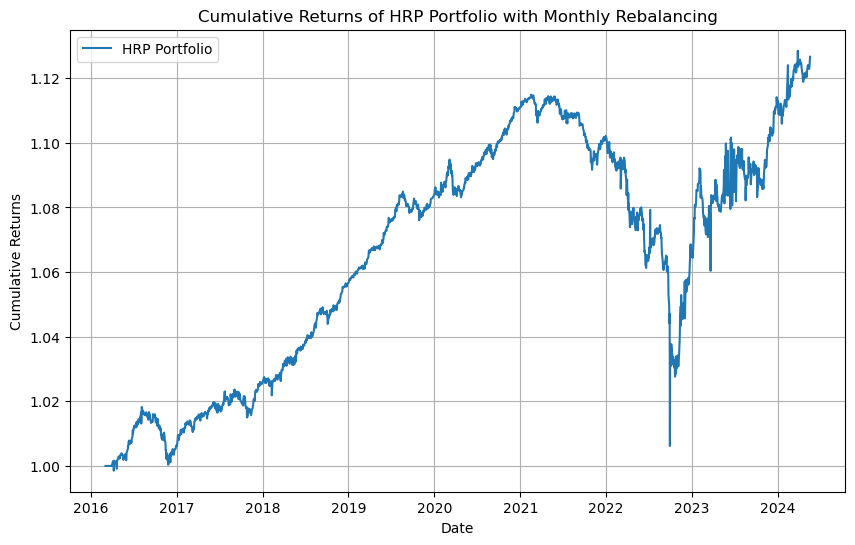

In [16]:


import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

# Calculate the pairwise correlations and distances
correlation_matrix = returns_df.corr()
distance_matrix = np.sqrt((1 - correlation_matrix) / 2)

# Perform hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix), method='ward')

# Display the linkage matrix
linkage_matrix[:5]  # Display the first 5 rows of the linkage matrix for brevity


import matplotlib.pyplot as plt
import numpy as np
def get_quasi_diag(link):
    """
    Sort clustered items by distance
    link: linkage matrix from scipy.cluster.hierarchy
    -> list of ordered indices
    """
    link = link.astype(int)
    sort_ix = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]  # number of original items
    
    while sort_ix.max() >= num_items:
        sort_ix.index = range(0, sort_ix.shape[0] * 2, 2)  # make space
        df0 = sort_ix[sort_ix >= num_items]  # find clusters
        i = df0.index
        j = df0.values - num_items
        sort_ix[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sort_ix = pd.concat([sort_ix, df0], ignore_index=True)
        sort_ix = sort_ix.sort_index()
        sort_ix.index = range(sort_ix.shape[0])
    return sort_ix.tolist()

def compute_hrp_weights(returns):
    correlation_matrix = returns.corr()
    distance_matrix = np.sqrt((1 - correlation_matrix) / 2)
    linkage_matrix = linkage(squareform(distance_matrix), method='ward')
    covariance_matrix = returns.cov()
    sort_ix = get_quasi_diag(linkage_matrix)
    hrp_weights = get_rec_bipart(covariance_matrix, sort_ix)
    return hrp_weights

def rebalance_portfolio(returns, rebalance_dates):
    portfolio_weights = []
    for date in rebalance_dates:
        hrp_weights = compute_hrp_weights(returns.loc[:date])
        portfolio_weights.append(hrp_weights)
    return pd.DataFrame(portfolio_weights, index=rebalance_dates)

def compute_portfolio_returns(returns, weights_df):
    portfolio_returns = pd.Series(0, index=returns.index)
    previous_date = weights_df.index[0]
    for date in weights_df.index[1:]:
        # Get the monthly returns
        monthly_returns = returns.loc[previous_date:date]
        # Get the weights for the current month
        weights = weights_df.loc[date].values
        # Compute the weighted returns for the month
        weighted_returns = (monthly_returns * weights).sum(axis=1)
        # Assign the weighted returns to the portfolio returns series
        portfolio_returns.loc[previous_date:date] = weighted_returns
        previous_date = date
    return portfolio_returns

# Define rebalance dates (monthly)
rebalance_dates = returns_df.resample('M').last().index

# Compute portfolio weights at each rebalance date
weights_df = rebalance_portfolio(returns_df, rebalance_dates)

# Compute portfolio returns based on the weights
portfolio_returns = compute_portfolio_returns(returns_df, weights_df)

# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label='HRP Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns of HRP Portfolio with Monthly Rebalancing')
plt.legend()
plt.grid(True)
plt.show()

